In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
!rm -rf runs/tcga*

In [122]:
tcga_tybalt_file_location = 'data/rescaled_minmax_target_df_sort.tsv.gz'

In [123]:
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1,  inplace=True)
rnaseq_df = rnaseq_df.dropna()
print(rnaseq_df.shape)
rnaseq_df.head(2)

(660, 4493)


,RPS4Y1,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,SLC34A2,...,ABCG5,METTL7A,FAM129A,C8orf48,CDK5R1,FAM81A,GDPD3,SMAGP,POU5F1B,CHST2
0,0.224604,0.459175,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.294505,...,0.414980,0.547677,0.681401,0.714029,0.921951,0.722627,0.888005,0.481132,0.469433,0.699463
1,0.359367,0.000000,0.489525,0.779279,0.0,0.0,0.672609,0.320814,0.213448,0.190110,...,0.233468,0.639364,0.871560,0.000000,0.457317,0.302613,0.728960,0.179363,0.369145,0.638640


In [124]:
test_set_percent = 0.2
rnaseq_df_test = rnaseq_df.sample(frac=test_set_percent)
rnaseq_df_train = rnaseq_df.drop(rnaseq_df_test.index)

In [125]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)


In [126]:
train_dataset = CustomDataset(rnaseq_df_train)
test_dataset = CustomDataset(rnaseq_df_test)

In [170]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5, shuffle=False)

In [171]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list, z_dim):
        super(VAE, self).__init__()
        
        self.z_dim = z_dim
        
        self.encoder_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim[0])])
        self.decoder_layers = nn.ModuleList([nn.Linear(hidden_dim[0], input_dim)])
                
        if len(hidden_dim)>1:
            for i in range(len(hidden_dim)-1):
                self.encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                self.decoder_layers.insert(0, nn.Linear(hidden_dim[i+1], hidden_dim[i]))
                
        self.encoder_layers.append(nn.Linear(hidden_dim[-1], 2 * z_dim))
        self.batchnorm = nn.BatchNorm1d(z_dim)
        self.decoder_layers.insert(0, nn.Linear(z_dim, hidden_dim[-1]))

        
    def encoder(self, x):
        for idx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if idx < len(self.encoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                x = F.relu(x)
                #x = nn.BatchNorm1d(x)
        return x[...,:self.z_dim], x[...,self.z_dim:] # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        # std = torch.abs(log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        for idx, layer in enumerate(self.decoder_layers):
            z = layer(z)
            if idx < len(self.decoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                z = F.relu(z)
        return torch.sigmoid(z) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, input_dim))
        mu = self.batchnorm(mu)
        log_var = self.batchnorm(log_var)
    #    z = self.sampling(mu, log_var)
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(torch.exp(0.5*log_var)))
        z = latent.rsample()
           
    #    return self.decoder(z), mu, log_var
        return self.decoder(z), latent

    @staticmethod
    def loss_function(recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD
    
    @staticmethod
    def loss_function_dist(recon_x, x, latent, input_dim):
        prior = MultivariateNormal(loc = torch.zeros(latent.mean.shape[1]),
                                   scale_tril=torch.eye(latent.mean.shape[1]))
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = torch.sum(kl_divergence(latent, prior))
        return BCE + KLD

In [172]:
 def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        
        # Every data instance 
        data = data.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        recon_batch, latent = vae(data)

        # Compute the loss and its gradients
        loss = VAE.loss_function_dist(recon_batch, data, latent, input_dim)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100.0 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [185]:
# build model
input_dim=rnaseq_df.shape[1]
#vae = VAE(input_dim=input_dim, hidden_dim=[100,100], z_dim=100)
vae = VAE(input_dim=input_dim, hidden_dim=[1024, 512, 256,100], z_dim=100)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
#train_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(torch.randn(30, 5000)), batch_size=100, shuffle=True)

DEVICE = 'cpu'
    
vae.to(DEVICE)

optimizer = optim.Adam(vae.parameters(), lr=0.0005)


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/tcga_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 50

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    vae.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    vae.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs = vdata
        voutputs, latent = vae(vinputs)
        
        vloss = VAE.loss_function_dist(voutputs, vinputs, latent, input_dim)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        #torch.save(vae.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 13877.4728125
LOSS train 13877.4728125 valid 18854.5390625
EPOCH 2:
  batch 100 loss: 13390.087216796876
LOSS train 13390.087216796876 valid 15741.5048828125
EPOCH 3:
  batch 100 loss: 13305.142236328125
LOSS train 13305.142236328125 valid 13913.77734375
EPOCH 4:
  batch 100 loss: 13120.191962890625
LOSS train 13120.191962890625 valid 14132.4873046875
EPOCH 5:
  batch 100 loss: 13135.529521484375
LOSS train 13135.529521484375 valid 13177.4931640625
EPOCH 6:
  batch 100 loss: 13133.653388671875
LOSS train 13133.653388671875 valid 13042.5048828125
EPOCH 7:
  batch 100 loss: 12993.528486328125
LOSS train 12993.528486328125 valid 12776.7724609375
EPOCH 8:
  batch 100 loss: 13071.069775390624
LOSS train 13071.069775390624 valid 12904.7236328125
EPOCH 9:
  batch 100 loss: 13069.694130859374
LOSS train 13069.694130859374 valid 12635.423828125
EPOCH 10:
  batch 100 loss: 13082.103017578125
LOSS train 13082.103017578125 valid 12738.4111328125
EPOCH 11:
  batch 100 los

In [174]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = vae.forward(torch.tensor(rnaseq_df_test.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns)

In [175]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
LRCH2,0.054567,0.096210
KCNT2,0.060122,0.093611
TCEAL7,0.053727,0.092304
HOXD8,0.065179,0.091088
CXXC4,0.040953,0.090973


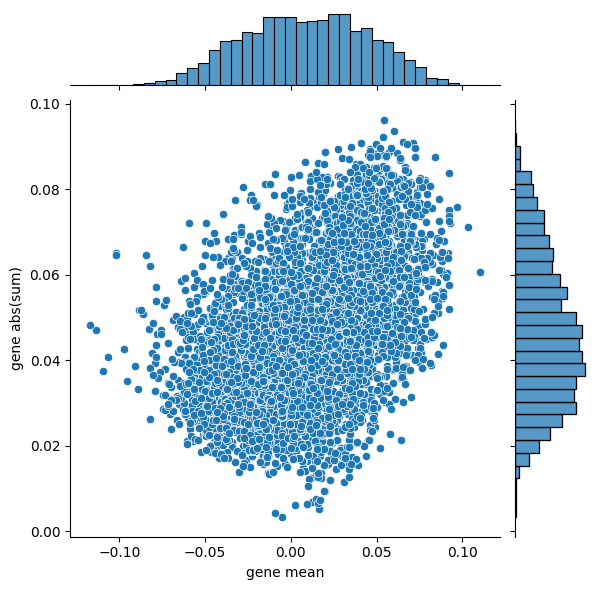

In [176]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

In [177]:
BCE_loss = []
KLD_loss = []
MSE_loss = []
# print row vectors next to each other in a loop
for i in range(len(rnaseq_df_test)):
    x = torch.Tensor(rnaseq_df_test.iloc[i].values)
    y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
    bce_loss = F.binary_cross_entropy(x, y)
    mse_loss = F.mse_loss(x,y)
    
    #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
    #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))
    
    #kld_loss = torch.sum(kl_divergence(x, prior).item())
    BCE_loss.append(bce_loss)
    MSE_loss.append(mse_loss)
    

In [178]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled


In [179]:
#1 percent of data shuffeled
rnaseq_df_1_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [180]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_rs = vae.forward(torch.tensor(rnaseq_df_1_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_rs = vae.forward(torch.tensor(rnaseq_df_3_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_rs = vae.forward(torch.tensor(rnaseq_df_5_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_rs = vae.forward(torch.tensor(rnaseq_df_8_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_rs = vae.forward(torch.tensor(rnaseq_df_10_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_rs = vae.forward(torch.tensor(rnaseq_df_20_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20_rs.detach().numpy(), columns=rnaseq_df.columns)

In [181]:
#compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y, reduction='sum')
        mse_loss = F.mse_loss(x,y, reduction='sum')

        #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        #kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss.numpy().item())
        MSE_loss.append(mse_loss.numpy().item())
        
    return BCE_loss, MSE_loss

In [182]:
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_1_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_5_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_8_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_10_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_20_rs)[0]))

19610.59043190696
35295.749467329544
35646.28472715436
36754.39481977983
38439.10995945786
46120.480124733665


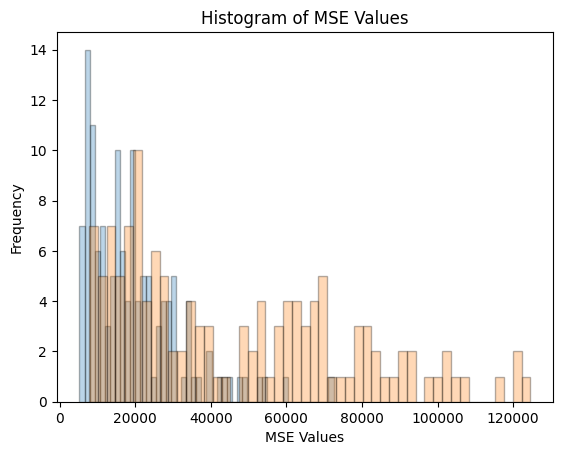

In [183]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_20_rs)[0], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

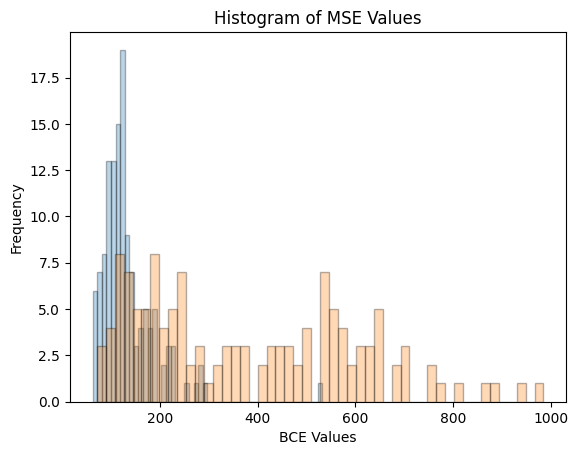

In [184]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_10_rs)[1], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('BCE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

In [60]:
F.binary_cross_entropy(torch.Tensor([0,0,0,0]), torch.Tensor([1,1,1,1]))

tensor(100.)